In [ ]:
!pip install  tensorflow
!pip install spectral
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import torch
import cv2
from operator import truediv



def set_figsize(figsize=(3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize


def classification_map(map, ground_truth, dpi, save_path):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(ground_truth.shape[1] * 2.0 / dpi,
                        ground_truth.shape[0] * 2.0 / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    ax.imshow(map)
    fig.savefig(save_path, dpi=dpi)
    return 0


def list_to_colormap(x_list):
    y = np.zeros((x_list.shape[0], 3))
    for index, item in enumerate(x_list):
        if item == 0:
            y[index] = np.array([255, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([0, 255, 0]) / 255.
        if item == 2:
            y[index] = np.array([0, 0, 255]) / 255.
        if item == 3:
            y[index] = np.array([255, 255, 0]) / 255.
        if item == 4:
            y[index] = np.array([0, 255, 255]) / 255.
        if item == 5:
            y[index] = np.array([255, 0, 255]) / 255.
        if item == 6:
            y[index] = np.array([192, 192, 192]) / 255.
        if item == 7:
            y[index] = np.array([128, 128, 128]) / 255.
        if item == 8:
            y[index] = np.array([128, 0, 0]) / 255.
        if item == 9:
            y[index] = np.array([128, 128, 0]) / 255.
        if item == 10:
            y[index] = np.array([0, 128, 0]) / 255.
        if item == 11:
            y[index] = np.array([128, 0, 128]) / 255.
        if item == 12:
            y[index] = np.array([0, 128, 128]) / 255.
        if item == 13:
            y[index] = np.array([0, 0, 128]) / 255.
        if item == 14:
            y[index] = np.array([255, 165, 0]) / 255.
        if item == 15:
            y[index] = np.array([255, 215, 0]) / 255.
        if item == 16:
            y[index] = np.array([0, 0, 0]) / 255.
        if item == 17:
            y[index] = np.array([215, 255, 0]) / 255.
        if item == 18:
            y[index] = np.array([0, 255, 215]) / 255.
        if item == -1:
            y[index] = np.array([0, 0, 0]) / 255.
    return y


def generate_png(all_iter, net, gt_hsi, Dataset, device, total_indices, path):
    pred_test = []
    for X, y in all_iter:
        X = X.permute(0, 3, 1, 2)
        X = X.to(device)
        net.eval()
        pred_test.extend(net(X).cpu().argmax(axis=1).detach().numpy())
    gt = gt_hsi.flatten()
    x_label = np.zeros(gt.shape)
    for i in range(len(gt)):
        if gt[i] == 0:
            gt[i] = 17
            x_label[i] = 16
    gt = gt[:] - 1
    x_label[total_indices] = pred_test
    x = np.ravel(x_label)
    y_list = list_to_colormap(x)
    y_gt = list_to_colormap(gt)
    y_re = np.reshape(y_list, (gt_hsi.shape[0], gt_hsi.shape[1], 3))
    gt_re = np.reshape(y_gt, (gt_hsi.shape[0], gt_hsi.shape[1], 3))
    classification_map(y_re, gt_hsi, 300,
                       path + '.png')
    classification_map(gt_re, gt_hsi, 300,
                       path + '_gt.png')
    print('------Get classification maps successful-------')


(610, 340, 103)
The class numbers of the HSI data is: 9
-----Importing Setting Parameters-----
Cross validation
all data shape (42776, 7, 7, 103)
all tensor label shape torch.Size([42776])
Train: [    0     1     2 ... 38494 38495 38496] | test: [    5     6    14 ... 38490 38492 38497]
(30798,)
iteration number  1
0
training on  cuda
epoch 1, train loss 0.001403, train acc 0.991, valida loss 0.000015, valida acc 0.996, time 96.2 sec
epoch 2, train loss 0.001509, train acc 0.994, valida loss 0.000046, valida acc 0.994, time 99.9 sec
epoch 3, train loss 0.074969, train acc 0.994, valida loss 0.000034, valida acc 0.995, time 101.2 sec
epoch 4, train loss 0.000151, train acc 0.996, valida loss 0.000033, valida acc 0.996, time 100.6 sec
epoch 5, train loss 0.000214, train acc 0.994, valida loss 0.000075, valida acc 0.997, time 99.6 sec
epoch 6, train loss 0.020688, train acc 0.995, valida loss 0.000268, valida acc 0.996, time 97.8 sec
epoch 7, train loss 0.000290, train acc 0.995, valida l

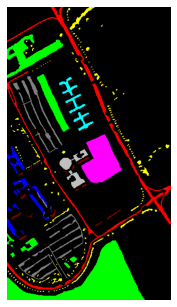

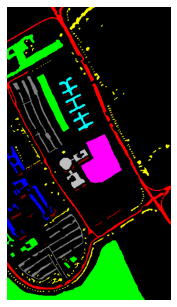

In [ ]:

import argparse
import collections
import math
import time

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


PARAM_DATASET = "UP"
PARAM_EPOCH = 1
PARAM_ITER = 5
PATCH_SIZE = 3
PARAM_VAL = 0.2
PARAM_OPTIM = 'adam'
# # Data Loading

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import numpy as np
import torch
from operator import truediv

def evaluate_accuracy(data_iter, net, loss, device):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
         for i, data in enumerate(data_iter, 0):
                  
            test_l_sum, test_num = 0, 0
            
            inputs, targets = data
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device)
                #print("y 1 ",y.shape)
            targets = targets.to(device)
                
            net.eval() 
            outputs = net(inputs)
                
                # Compute loss
            loss = loss_function(outputs, targets.long())
            acc_sum += (outputs.argmax(dim=1) == targets.to(device)).float().sum().cpu().item()
            test_l_sum += loss
            test_num += 1
            net.train() 
            n +=  targets.shape[0]
    return [acc_sum / n, test_l_sum] # / test_num]


def aa_and_each_accuracy(confusion_matrix):
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc



def record_output(oa_ae, aa_ae, kappa_ae, f1_ae, element_acc_ae, training_time_ae, testing_time_ae, path):
    f = open(path, 'a')
    sentence0 = 'OAs for each iteration are:' + str(oa_ae) + '\n'
    f.write(sentence0)
    sentence1 = 'AAs for each iteration are:' + str(aa_ae) + '\n'
    f.write(sentence1)
    sentence2 = 'KAPPAs for each iteration are:' + str(kappa_ae) + '\n'
    f.write(sentence2)
    sentence10 = 'F1 scores for each iteration are:' + str(f1_ae) + '\n' + '\n'
    f.write(sentence10)
    sentence3 = 'mean_OA ± std_OA is: ' + str(np.mean(oa_ae)) + ' ± ' + str(np.std(oa_ae)) + '\n'
    f.write(sentence3)
    sentence4 = 'mean_AA ± std_AA is: ' + str(np.mean(aa_ae)) + ' ± ' + str(np.std(aa_ae)) + '\n'
    f.write(sentence4)
    sentence5 = 'mean_KAPPA ± std_KAPPA is: ' + str(np.mean(kappa_ae)) + ' ± ' + str(np.std(kappa_ae)) + '\n' 
    f.write(sentence5)
    sentence11 = 'mean_F1 ± std_F1 is: ' + str(np.mean(f1_ae)) + ' ± ' + str(np.std(f1_ae)) + '\n' + '\n'
    f.write(sentence11)
    sentence6 = 'Total average Training time is: ' + str(np.sum(training_time_ae)) + '\n'
    f.write(sentence6)
    sentence7 = 'Total average Testing time is: ' + str(np.sum(testing_time_ae)) + '\n' + '\n'
    f.write(sentence7)
    element_mean = np.mean(element_acc_ae, axis=0)
    element_std = np.std(element_acc_ae, axis=0)
    sentence8 = "Mean of all elements in confusion matrix: " + str(element_mean) + '\n'
    f.write(sentence8)
    sentence9 = "Standard deviation of all elements in confusion matrix: " + str(element_std) + '\n'
    f.write(sentence9)
    f.close()
    


global Dataset  # UP,IN,SV, KSC
dataset = PARAM_DATASET  #input('Please input the name of Dataset(IN, UP, SV, KSC):')
Dataset = dataset.upper()


def load_dataset(Dataset, split=0.8):
    if Dataset == 'IN':
        mat_data = sio.loadmat('/content/drive/MyDrive/Indian_pines_corrected.mat')
        mat_gt = sio.loadmat('/content/drive/MyDrive/Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        K = 200
        TOTAL_SIZE = 10249
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'UP':
        uPavia = sio.loadmat('/content/drive/MyDrive/PaviaU.mat')
        gt_uPavia = sio.loadmat('/content/drive/MyDrive/PaviaU_gt.mat')
        data_hsi = uPavia['paviaU']
        gt_hsi = gt_uPavia['paviaU_gt']
        K = 103
        TOTAL_SIZE = 42776
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)


    shapeor = data_hsi.shape
    shapeor = np.array(shapeor)
    shapeor[-1] = K
    data_hsi = data_hsi.reshape(shapeor)

    return data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT


# # Pytorch Data Loader Creation
data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT = load_dataset(Dataset, PARAM_VAL)
print(data_hsi.shape)

image_x, image_y, BAND = data_hsi.shape

data = data_hsi.reshape(np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))

gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )

CLASSES_NUM = max(gt)
print('The class numbers of the HSI data is:', CLASSES_NUM)

print('-----Importing Setting Parameters-----')
ITER = PARAM_ITER
PATCH_LENGTH = PATCH_SIZE
lr, num_epochs, batch_size = 0.001, 100, 32
loss = torch.nn.CrossEntropyLoss()


img_rows = 2 * PATCH_LENGTH + 1
img_cols = 2 * PATCH_LENGTH + 1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]
VAL_SIZE = int(TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

F1 = []
KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))



data = data_hsi.reshape(np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
data = preprocessing.scale(data)

data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])

whole_data = data_

padded_data = np.lib.pad(
    whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH),
                 (0, 0)),
    'constant',
    constant_values=0)


# # Model






"""mobilenetv2 in pytorch
[1] Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen
    MobileNetV2: Inverted Residuals and Linear Bottlenecks
    https://arxiv.org/abs/1801.04381
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=9):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x
        
        return residual

class MobileNetV2(nn.Module):

    def __init__(self, class_num=9):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(103, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)
            
    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x
    
    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))
        
        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1
        
        return nn.Sequential(*layers)

def mobilenetv2():
    
    
    model = MobileNetV2()
    #summary(model, input_data=(BAND, img_rows, img_cols), verbose=1)
    
    return model




import torch
import numpy as np
import torch.utils.data as Data

def index_assignment(index, row, col, pad_length):
    new_assign = {}
    for counter, value in enumerate(index):
        assign_0 = value // col + pad_length
        assign_1 = value % col + pad_length
        new_assign[counter] = [assign_0, assign_1]
    return new_assign

def select_patch(matrix, pos_row, pos_col, ex_len):
    selected_rows = matrix[range(pos_row-ex_len, pos_row+ex_len+1)]
    selected_patch = selected_rows[:, range(pos_col-ex_len, pos_col+ex_len+1)]
    return selected_patch


def select_small_cubic(data_size, data_indices, whole_data, patch_length, padded_data, dimension):
    small_cubic_data = np.zeros((data_size, 2 * patch_length + 1, 2 * patch_length + 1, dimension))
    data_assign = index_assignment(data_indices, whole_data.shape[0], whole_data.shape[1], patch_length)
    for i in range(len(data_assign)):
        small_cubic_data[i] = select_patch(padded_data, data_assign[i][0], data_assign[i][1], patch_length)
    return small_cubic_data

def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [
            j for j, x in enumerate(ground_truth.ravel().tolist())
            if x == i + 1
        ]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes



print("Cross validation")
#kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []
iteration = 1

_, total_indices = sampling(1, gt)


gt_all = gt[total_indices] - 1


all_data = select_small_cubic(TOTAL_SIZE, total_indices, whole_data, PATCH_LENGTH, padded_data, INPUT_DIMENSION)
print("all data shape", all_data.shape)

del padded_data, whole_data, gt, data_,data 

loss_function = nn.CrossEntropyLoss()

import numpy as np
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data, gt_all, test_size=0.10, random_state=42)
all_tensor_testt = torch.from_numpy(X_test).type(torch.FloatTensor)#.unsqueeze(1)
all_tensor_testt_label = torch.from_numpy(y_test).type(torch.FloatTensor)
torch_dataset_testt = Data.TensorDataset(all_tensor_testt, all_tensor_testt_label)
del all_tensor_testt, all_tensor_testt_label, X_test
testloader = torch.utils.data.DataLoader(
                      torch_dataset_testt,
                      batch_size=16)# sampler=test_subsampler)

all_tensor_data = torch.from_numpy(all_data).type(torch.FloatTensor)#.unsqueeze(1)
all_tensor_data_label = torch.from_numpy(gt_all).type(torch.FloatTensor)
torch_dataset_all = Data.TensorDataset(all_tensor_data, all_tensor_data_label)
print("all tensor label shape", all_tensor_data_label.shape)

del all_tensor_data, all_tensor_data_label, all_data, gt_all
index_iter = 0
sfolder = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)


for train, test in sfolder.split(X_train, y_train):
    print('Train: %s | test: %s' % (train, test))
    print(train.shape)
    
    print("iteration number ", index_iter+1)
    print(index_iter)


    all_train = X_train[train]
    all_train_label = y_train[train]
    all_test = X_train[test]
    all_test_label = y_train[test]
    all_tensor_train = torch.from_numpy(all_train).type(torch.FloatTensor)#.unsqueeze(1)
    all_tensor_train_label = torch.from_numpy(all_train_label).type(torch.FloatTensor)
    all_tensor_test = torch.from_numpy(all_test).type(torch.FloatTensor)#.unsqueeze(1)
    all_tensor_test_label = torch.from_numpy(all_test_label).type(torch.FloatTensor)
    torch_dataset_train = Data.TensorDataset(all_tensor_train, all_tensor_train_label)
    torch_dataset_test = Data.TensorDataset(all_tensor_test, all_tensor_test_label)
    del all_train, all_test, all_tensor_train, all_tensor_test, all_train_label, all_tensor_test_label,all_tensor_train_label, all_test_label
        
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                          torch_dataset_train, 
                          batch_size=16)#, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(
                          torch_dataset_test,
                          batch_size=16)# sampler=test_subsampler)
    
    
    net = mobilenetv2()
    
    net.load_state_dict(torch.load('/content/drive/MyDrive/mobilenet_7_0.99_UP_.pt'))
    
    
    optimizer = optim.Adam(
        net.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0)
    time_1 = int(time.time())
    
    
    loss_list = [100]
    early_epoch = 0
    
    net = net.to(device)
    print("training on ", device)
    start = time.time()
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    tic1 = time.time()
    for epoch in range(0, 10):
         train_acc_sum, n = 0.0, 0
         time_epoch = time.time()
         lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(
             optimizer, 15, eta_min=0.0, last_epoch=-1)
      
         train_acc_sum, n = 0.0, 0
         time_epoch = time.time()
       #  Set current loss value
         current_loss = 0.0
     
           # Iterate over the DataLoader for training data
         for i, data in enumerate(trainloader, 0):
               
             batch_count, train_l_sum = 0, 0
             
             # Get inputs
             
             inputs, targets = data
             inputs = inputs.permute(0, 3, 1, 2)
             inputs = inputs.to(device)
              #print("y 1 ",y.shape)
             targets = targets.to(device)
             
             # Zero the gradients
             optimizer.zero_grad()
             
             # Perform forward pass
             outputs = net(inputs)
             
             # Compute loss
             loss = loss_function(outputs, targets.long())
             
             # Perform backward pass
             loss.backward()
             
             # Perform optimization
             optimizer.step()
             train_l_sum += loss.cpu().item()
             train_acc_sum += (outputs.argmax(dim=1) == targets).sum().cpu().item()
             n += targets.shape[0]
             batch_count += 1
         lr_adjust.step()
         valida_acc, valida_loss = evaluate_accuracy(
             valloader, net, loss, device)
         loss_list.append(valida_loss)
     
         train_loss_list.append(train_l_sum)  # / batch_count)
         train_acc_list.append(train_acc_sum / n)
         valida_loss_list.append(valida_loss)
         valida_acc_list.append(valida_acc)
     
         print(
             'epoch %d, train loss %.6f, train acc %.3f, valida loss %.6f, valida acc %.3f, time %.1f sec'
               % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
                 valida_loss, valida_acc, time.time() - time_epoch))
     
         PATH = "./net_DBA.pt"
         
         
         
    
    toc1 = time.time()         
    pred_test = []
    preddss = []
    gt_test = []
    tic2 = time.time()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
                  
            test_l_sum, test_num = 0, 0
            inputs, ttargets = data
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device)
            ttargets = ttargets.to(device)
            net.eval() 
            outputs = net(inputs)
            pred_test.extend(np.array(net(inputs).cpu().argmax(axis=1)))
            
    
       
    toc2 = time.time()
    collections.Counter(pred_test)
    # gt_test = gt[test] - 1
     #print("targets", ttargets.shape)
     #print("pred test", pred_test.shape)
     
   # gts = y_test[test]
    
    
    overall_acc = metrics.accuracy_score(pred_test, y_test)
    confusion_matrix = metrics.confusion_matrix(pred_test, y_test)
    each_acc, average_acc = aa_and_each_accuracy(confusion_matrix)
    print(each_acc.shape)
    kappa = metrics.cohen_kappa_score(pred_test, y_test)
    f1s = metrics.f1_score(y_test, pred_test, average='macro')
    
    torch.save(net.state_dict(),
         'mobilenet_'  + str(img_rows) + '_' + str(round(overall_acc, 3)) + '_' + Dataset +'_.pt')
    KAPPA.append(kappa)
    F1.append(f1s)
    OA.append(overall_acc)
    AA.append(average_acc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc
    index_iter = index_iter + 1

# # Map, Records
print("--------" + " Training Finished-----------")
record_output(
OA, AA, KAPPA, F1, ELEMENT_ACC, TRAINING_TIME, TESTING_TIME,
'./' + 'mobilenet_' + str(img_rows) + '_' + Dataset + '_split' +
str(VALIDATION_SPLIT) + '_lr' + str(lr) + PARAM_OPTIM + '.txt')


all_iter = Data.DataLoader(
    dataset=torch_dataset_all,  # torch TensorDataset format
    batch_size=batch_size,  # mini batch size
    shuffle=False, 
    num_workers=0, 
)
generate_png(
all_iter, net, gt_hsi, Dataset, device, total_indices,
'./' + 'mobilenet_' + str(img_rows) + '_' + Dataset
+ '_split' + str(VALIDATION_SPLIT) + 'lr' + str(lr) + PARAM_OPTIM)


In [ ]:
torch.save(net.state_dict(),
         'nasnet_'  + str(img_rows) +  '_' + Dataset +'_.pt')